In [2]:
import numpy as np
from numpy import loadtxt
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from scipy.constants import pi
from math import log, exp, sqrt, pow

# Constants
Mpl = 2e27		# Planck mass [eV]
s2eV = (6.582119569e-16)#	// Hz to eV
J2eV = (1. / 1.602176634e-19)#	// Joules to eV (1 / e)
m2eV = (1.973269804e-7)#	// m-1 to eV
K2eV = (8.617333262e-5)#	// Kelvin to eV
kg2eV = 5.609588604e35#	// from hbar/c2
T2eV = 2e-16 * 1e18#		// Tesla to eV2 conversion [eV2/T]
amu = 931.49410242e6	# atomic mass unit in eV

# physical constants
a = (1./137.)
pi = np.pi
me = 0.51099895000e6	# electron mass in eV

Rsun= 6.9598e+8	# solar radius in meters
Lsolar = 3.0128e28		# Solar luminosity [W]
Lsolar *= J2eV*s2eV		# solar luminosity [eV2]
rSolar = 6.957e8/m2eV		# solar radius in eV-1

plt.style.use("/home/yuangw/Documents/GitHub/Chameleons/chameleon_2406.01691/style.txt")	# import plot style
file = "/home/yuangw/Documents/GitHub/Chameleons/chameleon_2406.01691/data/"

### load the dataset in AGSS09 solar model 
reads solar model from AGSS09 files in data folder and outputs easy to use .dat files

In [3]:
# filter - create CSV files from solar model to feed to C++ program


########### open file ###############
# creates arrays of [r, T, Rho, 1H, 4He, 3He, 12C, 14N, 16O]
cols1 = np.array((1,2,3))
cols2 = np.arange(6, 35, 1)
cols = np.append(cols1, cols2)

rFrac, T, rho, H1, He4, He3, C12, C13, N14, N15, O16, O17, O18, Ne, Na, Mg, Al, Si, P, S, Cl, Ar, K, Ca, Sc, Ti, V, Cr, Mn, Fe, Co, Ni = np.loadtxt(file + 'AGSS09_solar_model_stripped.dat', usecols=cols).swapaxes(0,1)

# convert values to eV
T = T * K2eV	# temp from K to eV
rho = rho * 1e3 * np.power(m2eV, 3) * kg2eV	# density from g cm-3 to eV4
rReal = rFrac * Rsun / m2eV	# radial distance from m to eV-1


############# compute values ###############

# array of mass fractions
fracs = [H1, He4, He3, C12, C13, N14, N15, O16, O17, O18, Ne, Na, Mg, Al, Si, P, S, Cl,  Ar,  K,   Ca,  Sc,   Ti,  V,   Cr,  Mn, Fe, Co, Ni]
A = [1.00782503223, 4.00260325413, 3.01602932007, 12.0, 13.00335483507, 14.00307400443, 15.00010889888, 15.99491461957, 16.99913175650, 17.99915961286, 20.18, 22.99, 24.305, 26.982, 28.086, 30.974, 32.066, 35.453, 39.948, 39.098, 40.078, 44.956, 47.876, 50.942, 51.996, 54,938, 55.845, 58.933, 58.693]	# masses of ions https://wwwndc.jaea.go.jp/NuC/ 
Z = [1, 2, 2, 6, 6, 7, 7, 8, 8, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


# compute ion densities & electron density
ne = np.zeros(len(rReal))
ionDensities = np.empty((len(fracs), len(fracs[0])))

for i in range(len(rReal)):
	const = rho[i] / amu
	total = 0
	for j in range(len(fracs)):
		ions = const * fracs[j][i] / A[j]
		ionDensities[j][i] = ions	# ion number densities in eV3
		
		electrons = ions * Z[j]
		total += electrons
		
	ne[i] = total

nH, nHe4, nHe3 = ionDensities[0:3, :]

# compute nbar = sum_i(Z_i^2 n_i)
nbar = np.zeros(len(ne))
nbar+=ne
for i in range(len(Z)):
	nbar+=Z[i]*Z[i]*ionDensities[i]		
nbar2 = nbar - ne
# compute plasma frequency
wp2 = np.multiply(( 4 * pi * a / (me) ) , ne)
wp = np.sqrt(wp2)
# compute Debye screening scale
kappa2 = 4*pi*a*nbar/T
kappa = np.sqrt(kappa2)

# save computed data
np.savetxt(file + 'rFrac.dat', rFrac, delimiter=',')
np.savetxt(file + 'r.dat', rReal, delimiter=',')
np.savetxt(file + 'T.dat', T, delimiter=',')
np.savetxt(file + 'ne.dat', ne, delimiter=',')
np.savetxt(file + 'wp.dat', wp, delimiter=',')
np.savetxt(file + 'nH.dat', nH, delimiter=',')
np.savetxt(file + 'nHe4.dat', nHe4, delimiter=',')
np.savetxt(file + 'nHe3.dat', nHe3, delimiter=',')
np.savetxt(file + 'rho.dat', rho, delimiter=',')
np.savetxt(file + 'nbar.dat', nbar, delimiter=',')
np.savetxt(file + 'nbar2.dat', nbar2, delimiter=',')
np.savetxt(file + 'kappa.dat', kappa, delimiter=',')



### plot solar model

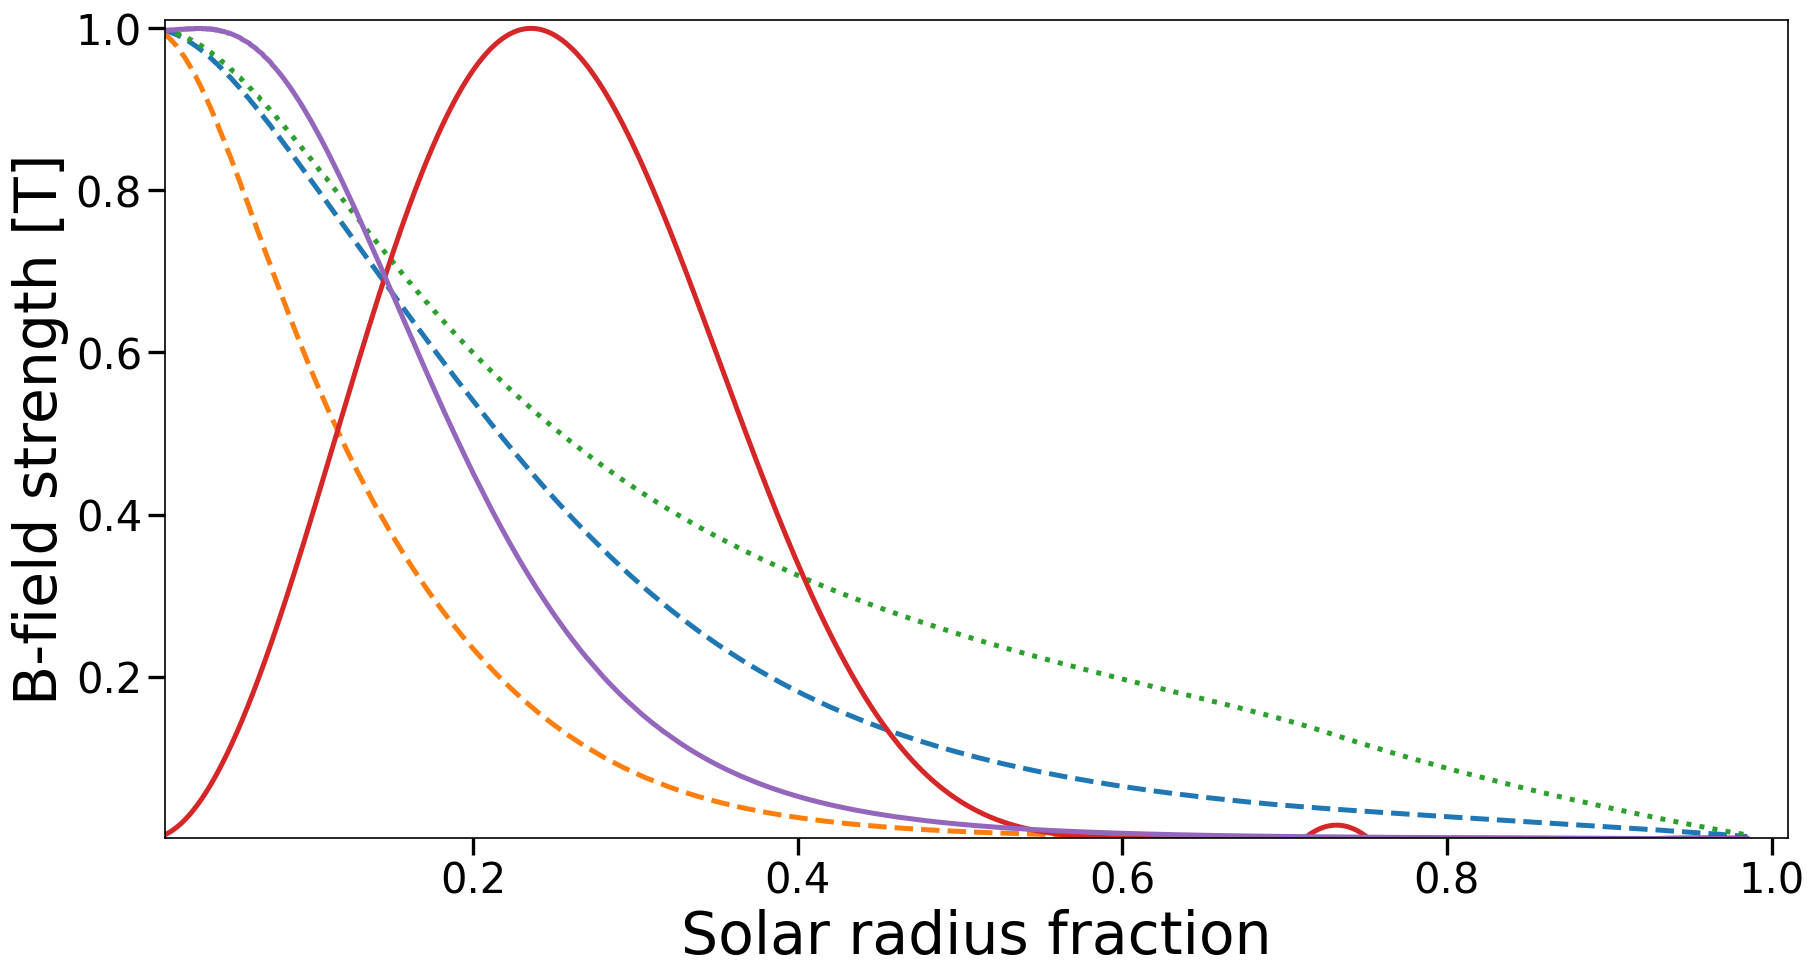

In [4]:
fig2 = plt.figure(1)	# display is 1920 x 1080 (16:9)
ax2 = fig2.subplots()
ax2.set(xlim=(1e-2,1.01), ylim=(1e-3,1.01))
#ax2.set(xlim=(0,1), ylim=(0,3.05e3))


# radius (fraction)
r = loadtxt(file + "rFrac.dat")

# plasma freq
dat = loadtxt(file + "wp.dat")
dat = dat / np.nanmax(dat)
ax2.plot(r,dat, label='Plasma frequency', ls='--')

# density
dat = loadtxt(file + "rho.dat")
dat = dat / np.nanmax(dat)
ax2.plot(r,dat, label='Density', ls='--')

# temperature
dat = loadtxt(file + "T.dat")
dat = dat / np.nanmax(dat)
ax2.plot(r,dat,label="Temperature",ls=':')

# B-field
dat = loadtxt(file + "Bfields-R.dat")
dat[:,1] = dat[:,1] / np.nanmax(dat[:,1])
ax2.plot(dat[:,0],dat[:,1],label="Magnetic field strength",ls='-')


# electron number density
# dat = loadtxt(file + "ne.dat")
# dat = dat / np.nanmax(dat)
# ax2.plot(r,dat,label="Electron number density")

# H number density
dat = loadtxt(file + "nH.dat")
dat = dat / np.nanmax(dat)
ax2.plot(r,dat,label="H number density")

# 3He number density
#dat = loadtxt(file + "nHe3.dat")
#dat = dat / np.nanmax(dat)
#ax2.plot(r,dat,label="3He number density")

# 4He number density
#dat = loadtxt(file + "nHe4.dat")
#dat = dat / np.nanmax(dat)
#ax2.plot(r,dat,label="4He number density")

# 57Fe number density
#dat = loadtxt(file + "n57Fe.dat")
#dat = dat / np.nanmax(dat)
#ax2.plot(r,dat,label="57Fe number density",ls='-.')

# axes
ax2.set_xlabel("Solar radius fraction")
#ax2.set_ylabel("Solar parameters (normalised)")
ax2.set_ylabel("B-field strength [T]")
#ax2.set_xscale('log')
#ax2.set_yscale('log')
#ax2.legend()

plt.tight_layout()
name = "solarmodel-lin"
# plt.savefig('plots/pdfs/{}.pdf'.format(name))
plt.show()

### plot Debye screening scale

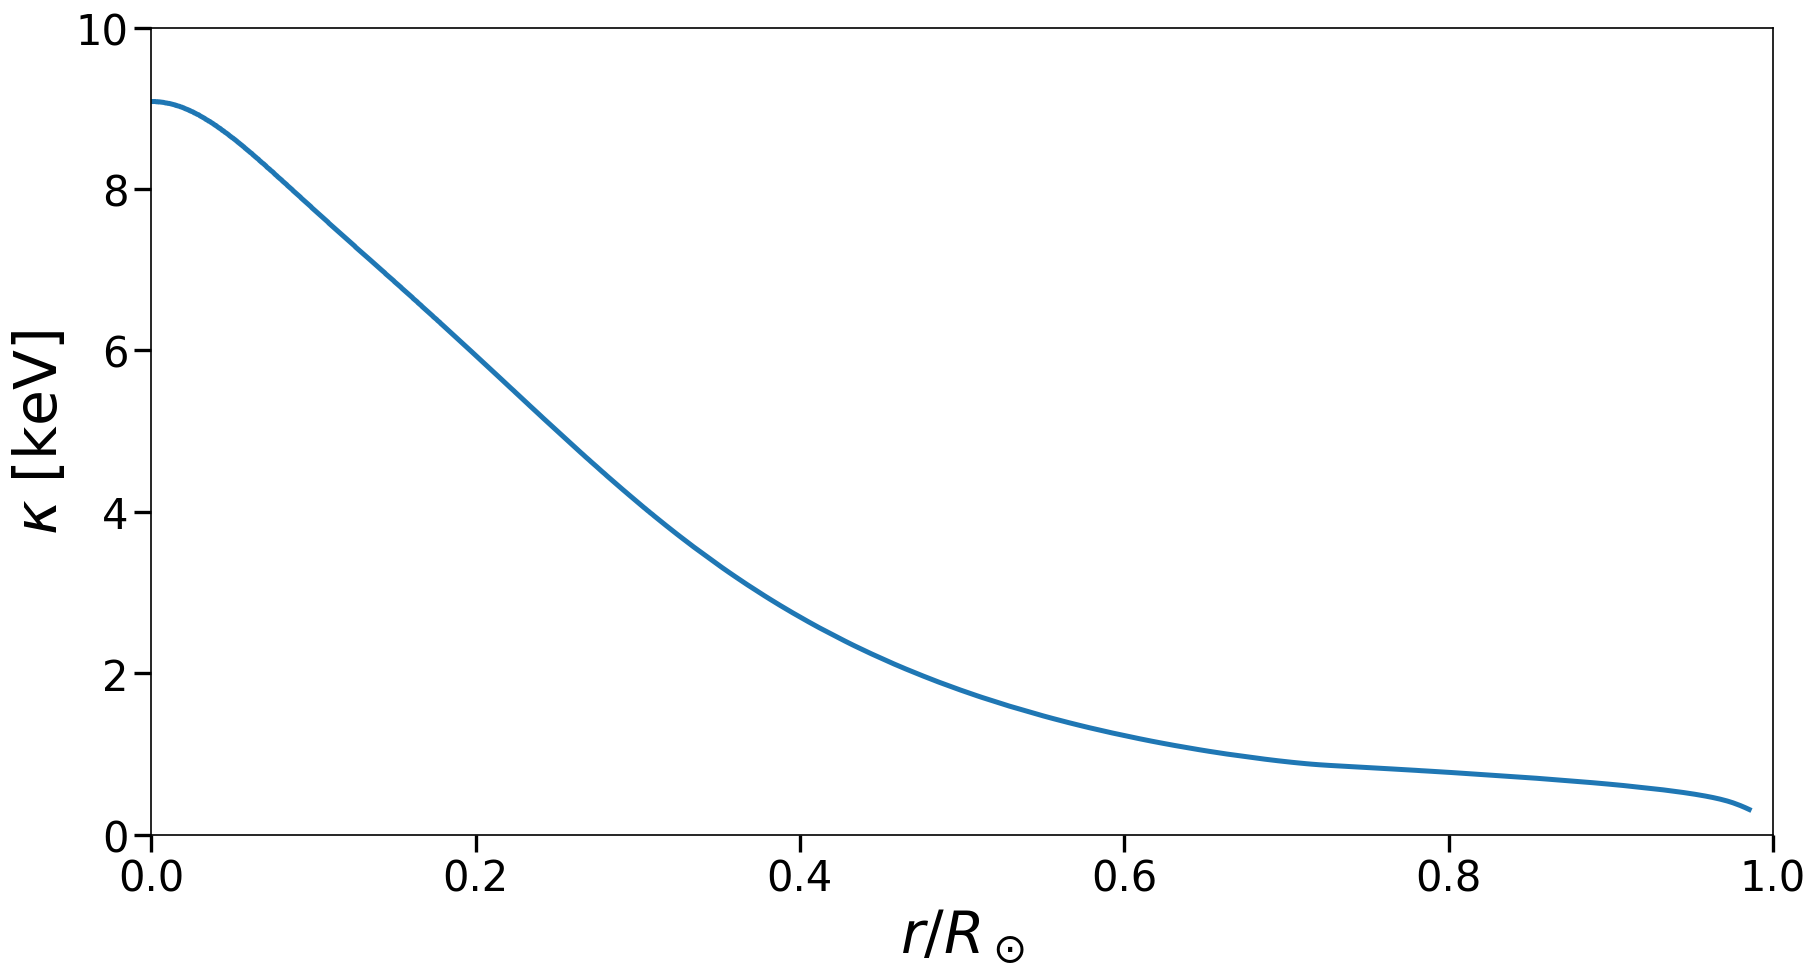

In [5]:
# plot Debye screening scale

# setup plot
fig2 = plt.figure(1)	# display is 1920 x 1080 (16:9)
#ax2 = fig2.add_axes((.15,.15,.8,.8))
ax2 = fig2.subplots()
ax2.set(xlim=(0,1), ylim=(0, 10))

# Electron/Ion T
r = loadtxt(file + "r.dat")
kappa = loadtxt(file + "kappa.dat")
ax2.plot(r/rSolar, kappa/1e3, ls='-', label="kappa")

# axes
ax2.set_xlabel(r'$r/R_\odot$')
ax2.set_ylabel(r'$\kappa$ [keV]')	#[m-2 s-1 eV-1]")
#ax2.set_xscale('log')
#ax2.set_yscale('log')
#ax2.legend()

plt.tight_layout()
name = "kappa_r"
# plt.savefig('plots/pdfs/{}.pdf'.format(name))
plt.show()


### plot Lambda against Bm chameleon bounds

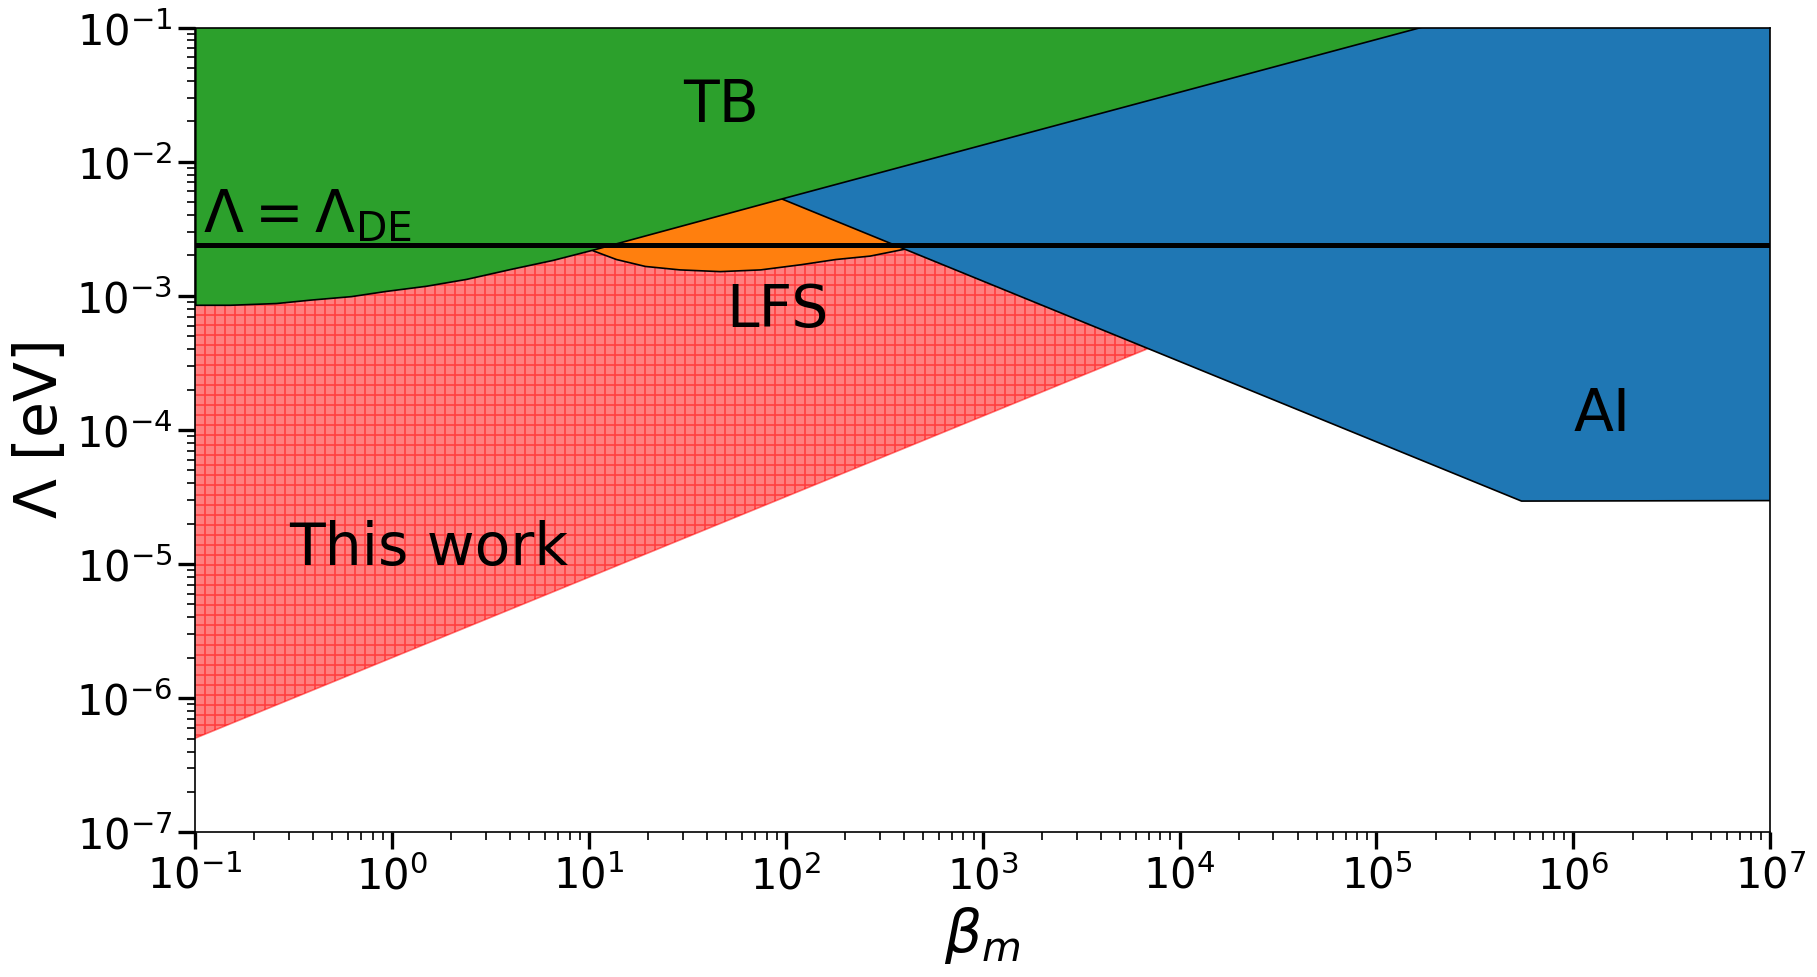

In [6]:
nticks=100

# setup plot
fig2 = plt.figure(1)	# display is 1920 x 1080 (16:9)
ax2 = fig2.subplots()
#ax2.set(xlim=(1e-1,1e18), ylim=(1e-8, 1e1))
ax2.set(xlim=(1e-1,1e7), ylim=(1e-7, 1e-1))
v = np.logspace(1e-20,1e0,nticks)

# plot DE scale
ax2.hlines(2.4e-3, 1e-1, 1e18, color='black', ls='-',zorder=10)
ax2.text(1.1e-1,3e-3,r'$\Lambda=\Lambda_{\mathrm{DE}}$',zorder=10)
#ax2.text(1e11,3e-3,r'$\Lambda=\Lambda_{\mathrm{DM}}$')

# plot "cutoff"
Lam = np.logspace(-18,1,100)
def Beta2(L):
	return 4.85532e9 * pow(L,1.53724)
np.vectorize(Beta2)

def Beta(L):
	return np.power(10,9.49285) * np.power(L,1.66571)
np.vectorize(Beta)
#Bm = 1/Beta(Lam)
ax2.fill_between(Beta(Lam),Lam,1e15,ec='black',ls='-',label='This work',color='r',alpha=0.5,hatch='++',zorder=0.1)
ax2.text(3e-1,1e-5,"This work")
#ax2.text(1e0,1e-5,"This work")

# plot other bounds
#dat = np.loadtxt("data/casimir.dat", delimiter=',')
#print(dat[:,1])
#ax2.plot(dat[:,0],dat[:,1],ls=':',label='Casimir')

dat = np.loadtxt(file + "interferometry.dat", delimiter=',')
ax2.fill_between(1/dat[:,0],dat[:,1],1e15,ec='black',ls='-',label='AI')
ax2.text(1e6,1e-4,"AI")

dat = np.loadtxt(file + "lfs.dat", delimiter=',')
ax2.fill_between(1/dat[:,0],dat[:,1],1e15,ec='black',ls='-',label='LFS',zorder=0.2)
ax2.text(5e1,6e-4,"LFS")

dat = np.loadtxt(file + "torsionbalance.dat", delimiter=',')
ax2.fill_between(1/dat[:,0],dat[:,1],1e15,ec='black',ls='-',label='TB')
ax2.text(3e1,2e-2,"TB")

# axes
ax2.set_xlabel(r'$\beta_m$')
ax2.set_ylabel(r'$\Lambda$ [eV]')	#[m-2 s-1 eV-1]")
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.legend(loc='lower right')

plt.tight_layout()
name = "casimirplot_Bm--fill--reduced--2"
# plt.savefig('plots/pdfs/{}.pdf'.format(name))
plt.show()

### plot Bm limits against n

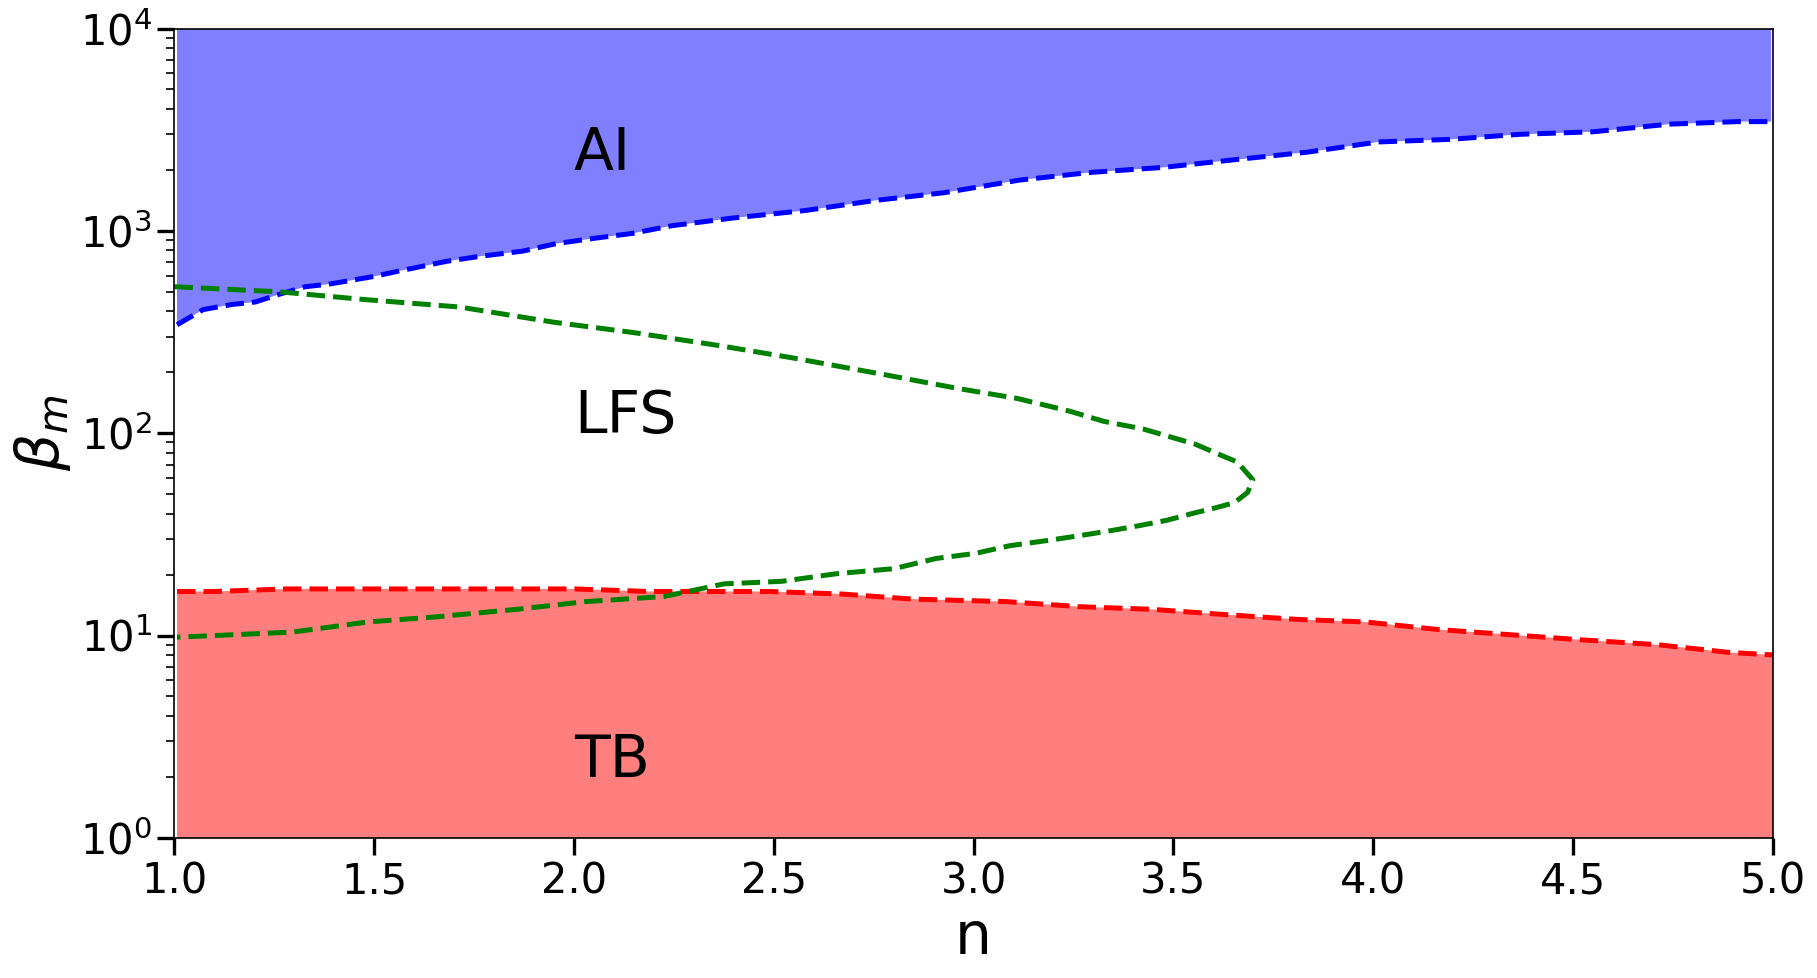

In [7]:
fig2 = plt.figure(1)	# display is 1920 x 1080 (16:9)
#ax2 = fig2.add_axes((.15,.15,.8,.8))
ax2 = fig2.subplots()
ax2.set(xlim=(1,5), ylim=(1e0, 1e4))


dat = loadtxt(file + "AI_n.csv",delimiter=',')
ax2.plot(dat[:,0],dat[:,1],color='blue', ls='--')
ax2.text(2,2e3,"AI")
plt.fill_between(dat[:,0],1e7,dat[:,1], facecolor='blue', alpha=0.5)

dat = loadtxt(file + "TP_n.csv",delimiter=',')
ax2.plot(dat[:,0],dat[:,1],color='red', ls='--')
ax2.text(2,2e0,"TB")
plt.fill_between(dat[:,0],dat[:,1],0, facecolor='red', alpha=0.5)

dat = loadtxt(file + "LFS_n.csv",delimiter=',')
ax2.plot(dat[:,0],dat[:,1],color='green', ls='--')
ax2.text(2,1e2,"LFS")
#dat2 = loadtxt("data/LFS_n-2.csv",delimiter=',')
#ax2.plot(dat2[:,0],dat2[:,1],color='red', ls='-')
#plt.fill_between(dat[:,0],dat2[:,1],dat[:,1], facecolor='red', alpha=0.5)


# axes
ax2.set_xlabel("n")
ax2.set_ylabel(r'$\beta_m$')
#ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.legend(loc='lower right')

plt.tight_layout()
name = "limits_n"
#plt.savefig('plots/pdfs/{}.pdf'.format(name))
plt.show()

### plot chameleon potential

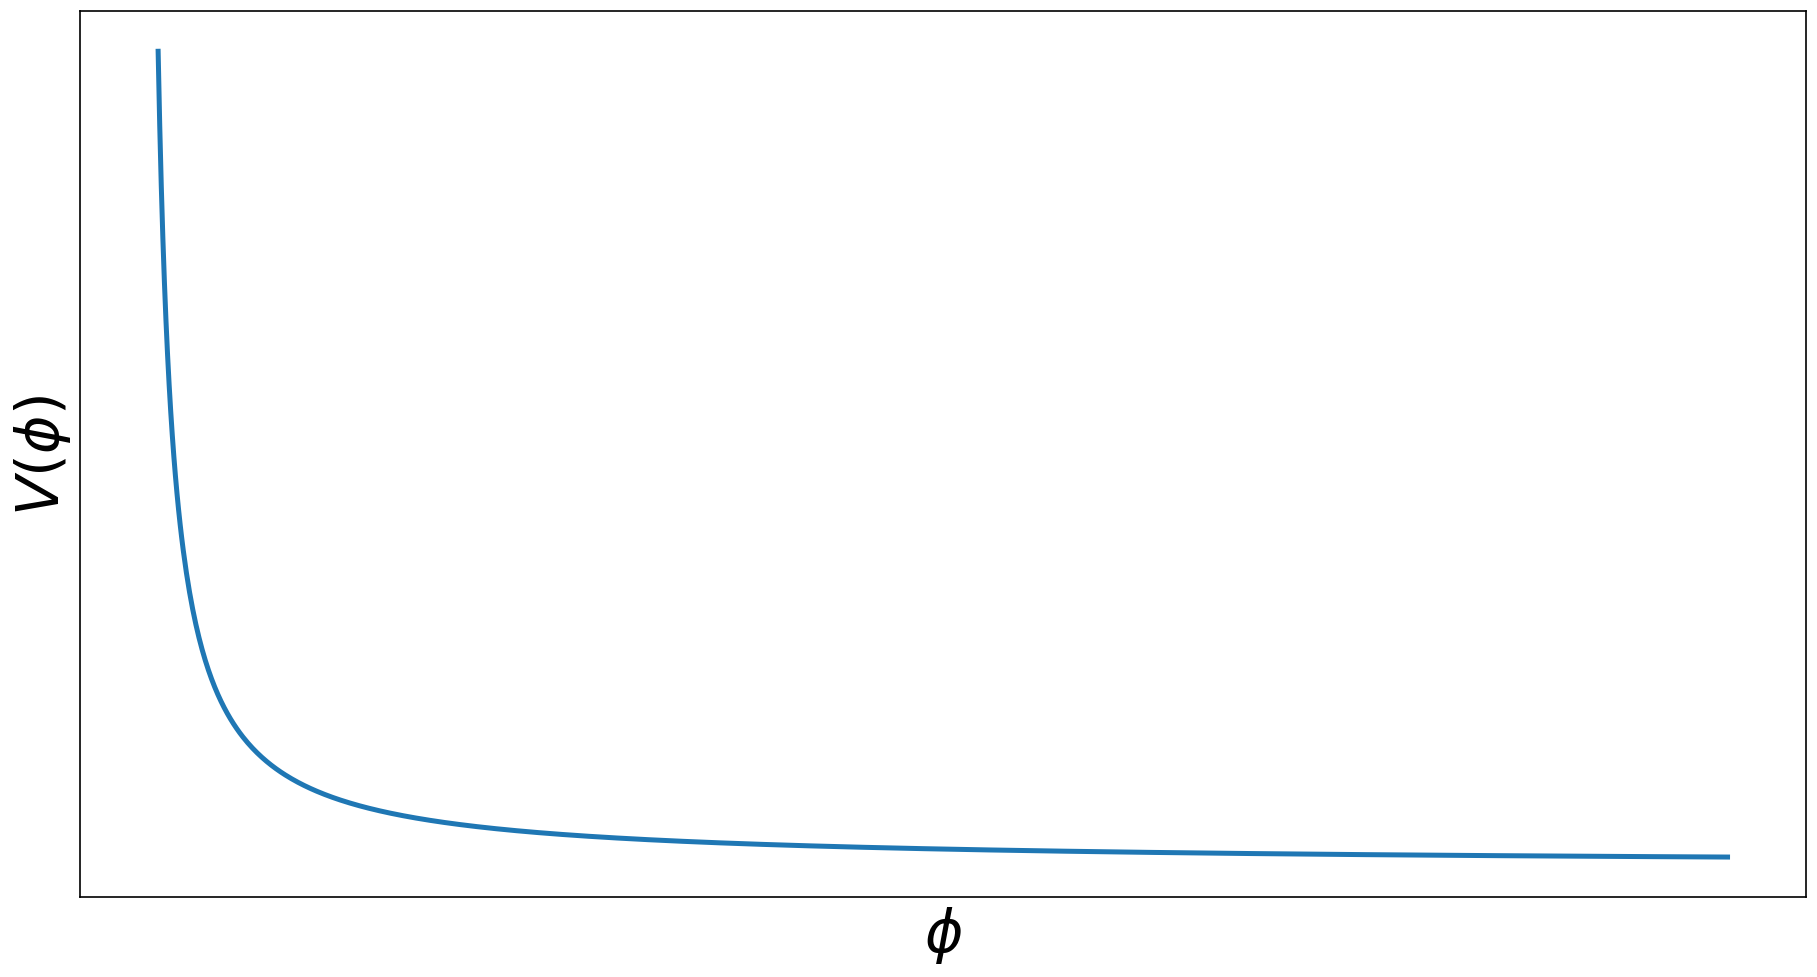

In [8]:
fig2 = plt.figure(1)	# display is 1920 x 1080 (16:9)
ax2 = fig2.subplots()
#ax2.set(xlim=(0,4), ylim=(0, 8e-13))
n = 1
Lambda = 1
rho = 1

def V(x): return (Lambda**(n+4))/(x**n)
np.vectorize(V)

def U(x): return rho*x
np.vectorize(U)

phi = np.linspace(1e-1,10,1000)
ax2.plot(phi,V(phi), ls='-', label=r'$V(\phi)$')
#ax2.plot(phi,U(phi), ls=':', label=r'$\rho \phi$')
#ax2.plot(phi,V(phi)+U(phi), ls='-', label=r'$V_{\mathrm{eff}}(\phi)$')
 
# axes
ax2.set_ylabel(r'$V(\phi)$')
ax2.set_xlabel(r'$\phi$')	#[m-2 s-1 eV-1]")
ax2.set_xticks([])
ax2.set_yticks([])
#ax2.set_yscale('log')
#ax2.legend()

plt.tight_layout()
name = "potential--nolabel"
# plt.savefig('plots/pdfs/{}.pdf'.format(name))
plt.show()

### plot solar chameleon energy loss bound

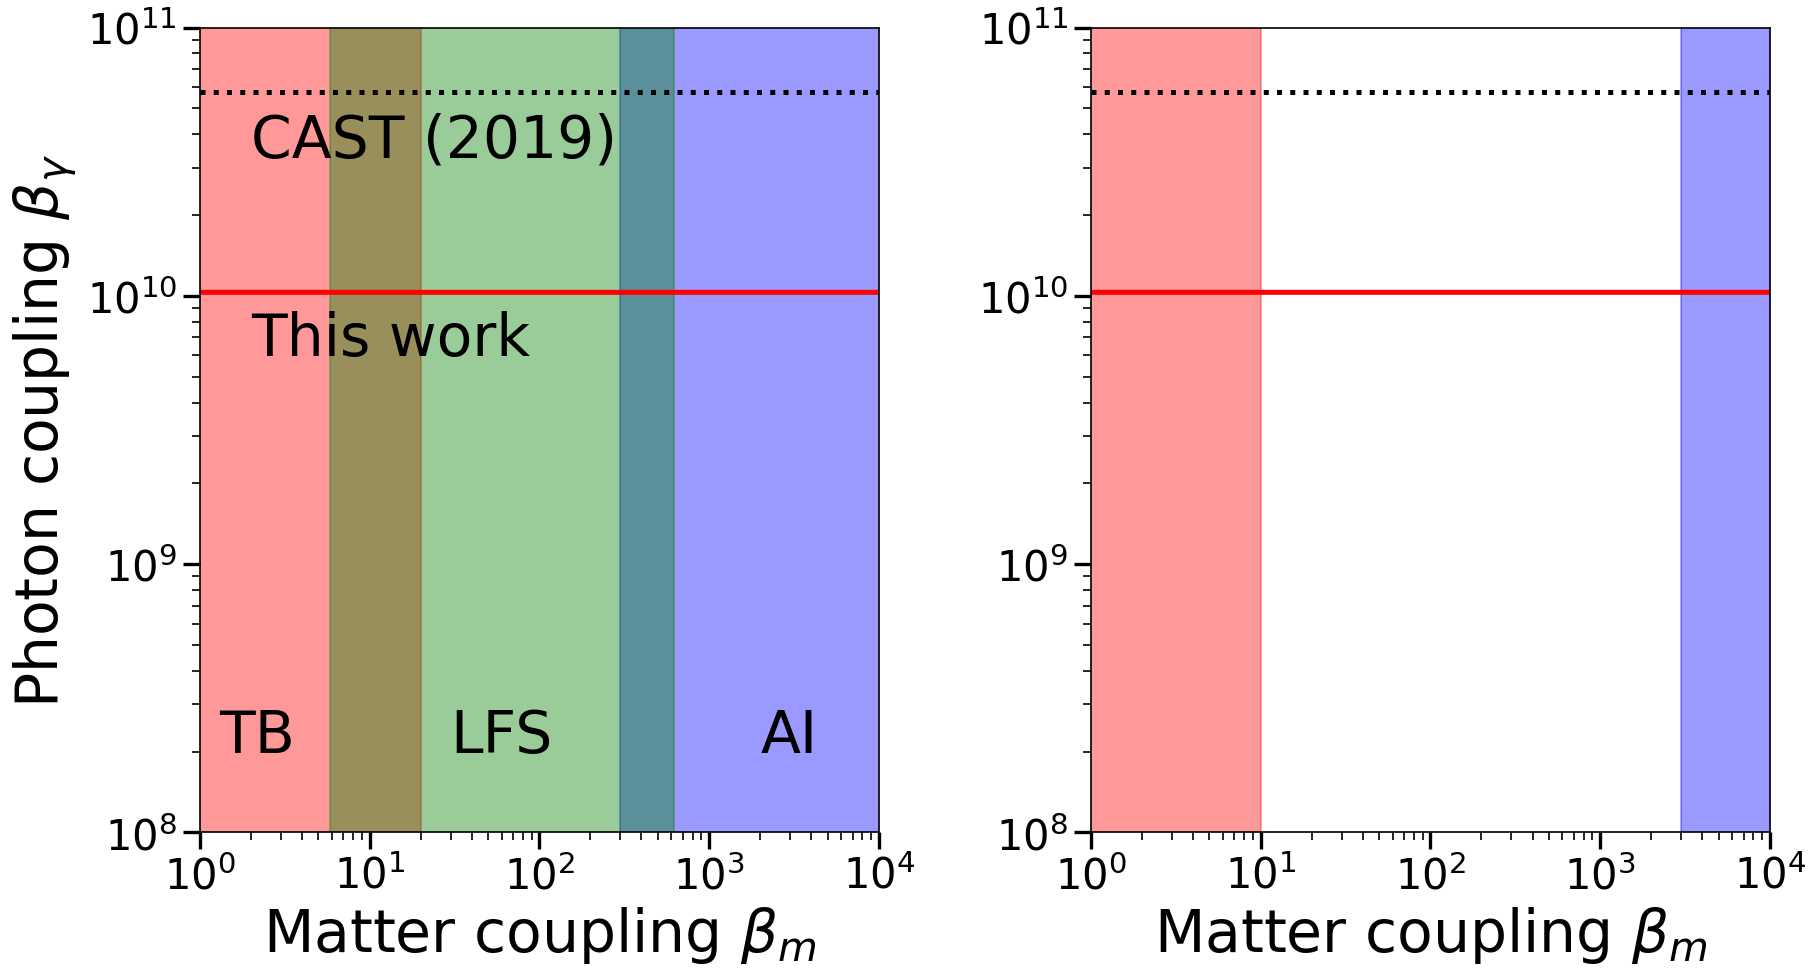

In [9]:
# IAXO expected background	[eV3 keV-1]
babybkg = 1e-7*1e4*m2eV*m2eV*s2eV
basebkg = 1e-8*1e4*m2eV*m2eV*s2eV
plusbkg = 1e-9*1e4*m2eV*m2eV*s2eV
castbkg = 1e-5*1e4*m2eV*m2eV*s2eV


# setup plot
fig, (ax1,ax2) = plt.subplots(1, 2)	# display is 1920 x 1080 (16:9)
fig2 = plt.figure(1)	# display is 1920 x 1080 (16:9)
#ax2 = fig2.add_axes((.1,.1,.8,.8))
ax1.set(xlim=(1e0, 1e4), ylim=(1e8, 1e11))
ax2.set(xlim=(1e0, 1e4), ylim=(1e8, 1e11))


############### n=1 ####################

# add CAST
ax1.hlines(5.74e10, 1e0, 1e11, color='black', ls=':', label='CAST')
ax1.text(2e0,3.3e10,"CAST (2019)")

dat = loadtxt(file + "Eloss_Bm_T.dat")
#dat = loadtxt("data/primakoff_total_Eloss_tach.dat")
Bg = np.sqrt(Lsolar*3/100/dat[:,1])
#print(Bg)
ax1.plot(dat[:,0],Bg, ls='-', color='r',label='This work')
ax1.text(2e0,6e9,"This work")

#dat = loadtxt("data/CAST_new_totalflux.dat")
##dat = loadtxt("data/primakoff_total_Eloss_tach.dat")
#Bg = power(dat[:,1]/castbkg, -1/4)
#print(Bg)
#ax1.plot(dat[:,0],Bg, ls=':', color='k',label='CAST new (estimate)')
#ax1.text(2e0,6.5e8,"CAST (new)")

#dat = loadtxt("data/CAST_Brax_totalflux.dat")
#dat = loadtxt("data/primakoff_total_Eloss_tach.dat")
#Bg = power(dat[:,1]/castbkg, -1/4)
#ax1.plot(dat[:,0],Bg, ls=':', color='b',label='CAST old (Brax)')
#ax1.text(2e0,4e9,"This work")


# add other limits
ax1.add_patch( Rectangle( (2e1, 1e-3), -1e11, 1e12, color='r', alpha=0.4, label='Torsion balance') )
ax1.text(1.3e0,2e8,"TB")
ax1.add_patch( Rectangle( (3e2, 1e-3), 1e11, 1e12, color='b', alpha=0.4, label='Atom interferometry') )
ax1.text(2e3,2e8,"AI")
ax1.add_patch( Rectangle( (5.88, 1e-3), 619, 1e12, color='g', alpha=0.4, label='Levitated force sensor') )
ax1.text(3e1,2e8,"LFS")

# axes
ax1.set_xlabel(r'Matter coupling $\beta_m$')
ax1.set_ylabel(r'Photon coupling $\beta_\gamma$')
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.legend()#loc='lower right')


############### n=4 ####################
dat = loadtxt(file + "Eloss_Bm_T.dat")
Bg = np.sqrt(Lsolar*3/100/dat[:,1])
ax2.plot(dat[:,0],Bg, ls='-',color='r', label='This work')

# add CAST
ax2.hlines(5.74e10, 1e0, 1e11, color='black', ls=':', label='CAST')

# add other limits
ax2.add_patch( Rectangle( (1e1, 1e-10), -1e11, 1e12, color='r', alpha=0.4, label='Torsion balance') )
ax2.add_patch( Rectangle( (3e3, 1e-10), 1e11, 1e12, color='b', alpha=0.4, label='Atom interferometry') )
#ax2.add_patch( Rectangle( (3e1, 1e7), 7e1, 1e12, color='g', alpha=0.4, label='Levitated force sensor') )
ax2.add_patch( Rectangle( (3e100, 1e-10), 7e1, 1e12, color='g', alpha=0.4, label='Levitated force sensor') )

# axes
ax2.set_xlabel(r'Matter coupling $\beta_m$')
#ax2.set_ylabel(r'Photon coupling $\beta_\gamma$')
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.legend(loc='lower right')

plt.tight_layout()
name = "solarLimits_n1n4"
#plt.savefig('plots/pdfs/{}.pdf'.format(name))
plt.show()

### plot scalar primakoff profile

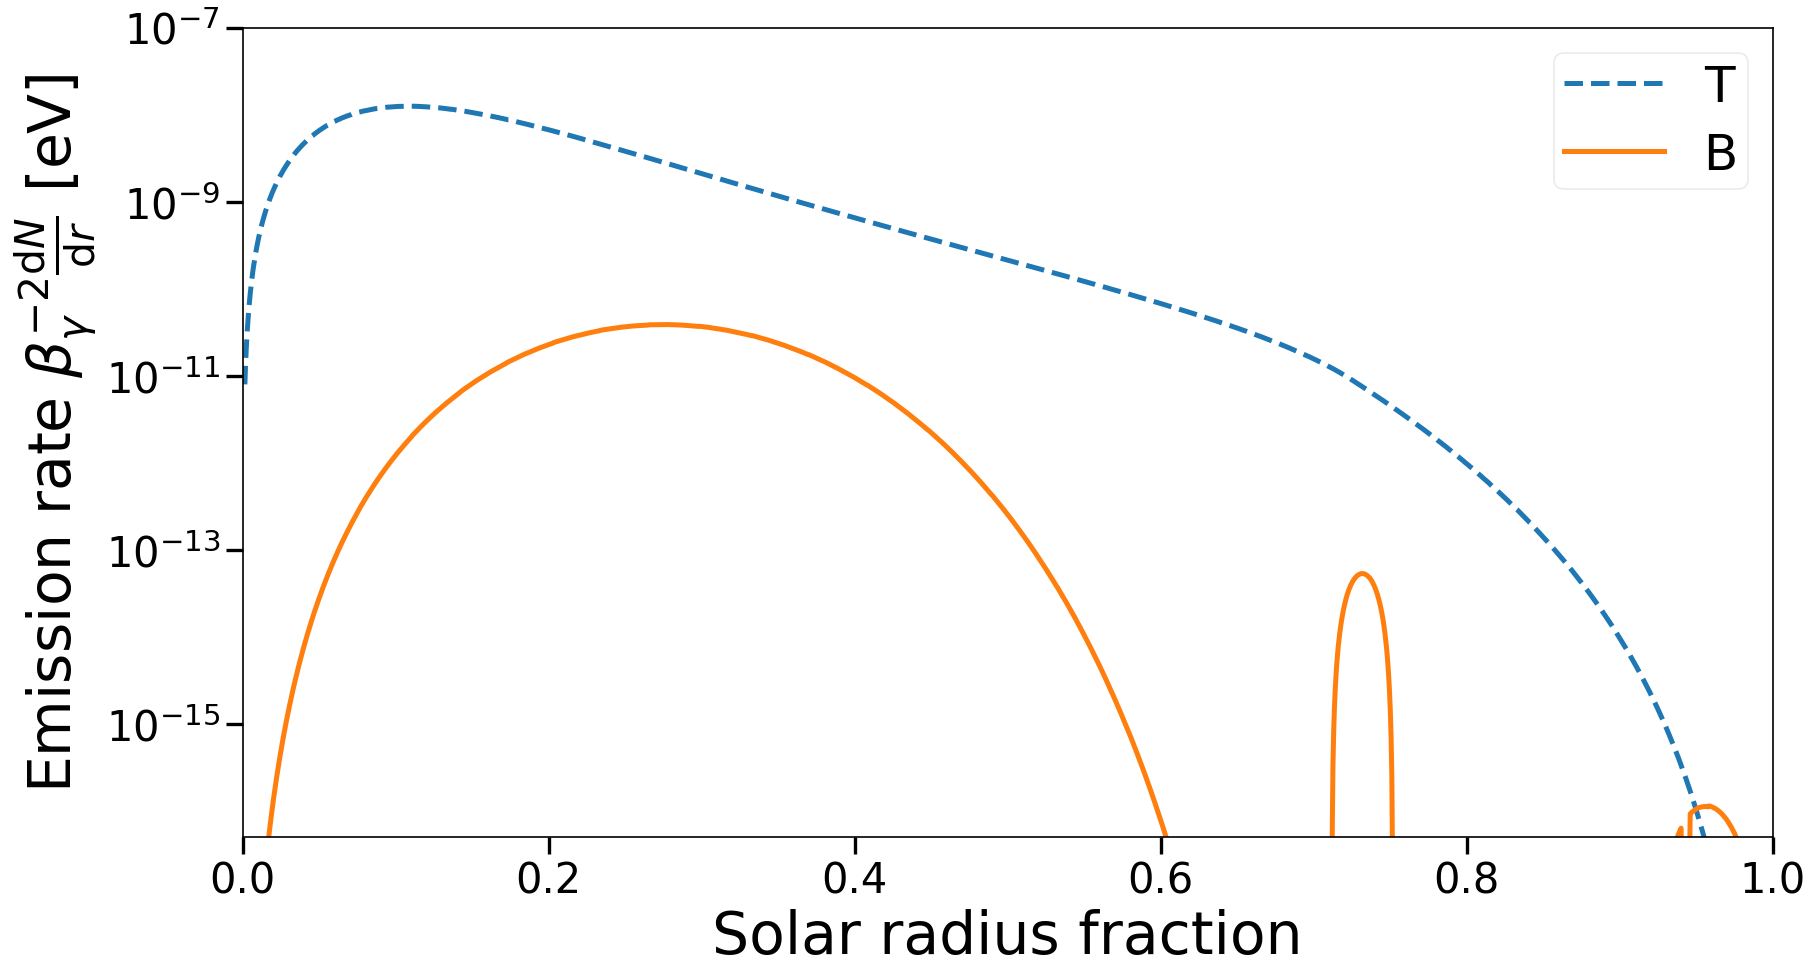

In [10]:
R = 6.9598E+8/(1.973269804e-7);	# solar radius [eV-1]

fig2 = plt.figure(1)	# display is 1920 x 1080 (16:9)
ax2 = fig2.subplots()
ax2.set(xlim=(0,1), ylim=(5e-17, 1e-7))
#ax2.set(xlim=(0,1), ylim=(0, 1.02e49))

dat = loadtxt(file + "T_profile_1e2.dat")
#dat[:,1] = dat[:,1]/np.nanmax(dat[:,1])
ax2.plot(dat[:,0]/R,dat[:,1], ls='--',label='T')

dat = loadtxt(file + "B_profile_1e2.dat")
#dat[:,1] = dat[:,1]/np.nanmax(dat[:,1])
ax2.plot(dat[:,0]/R,dat[:,1], ls='-',label='B')

# axes
ax2.set_xlabel("Solar radius fraction")
ax2.set_ylabel(r'Emission rate $\beta_\gamma^{-2} \frac{\mathrm{d}N}{\mathrm{d}r}$ [eV]')
#ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()

plt.tight_layout()
name = "profile-log"
# plt.savefig('plots/pdfs/{}.pdf'.format(name))
plt.show()

### Plot scalar primakoff spectrum

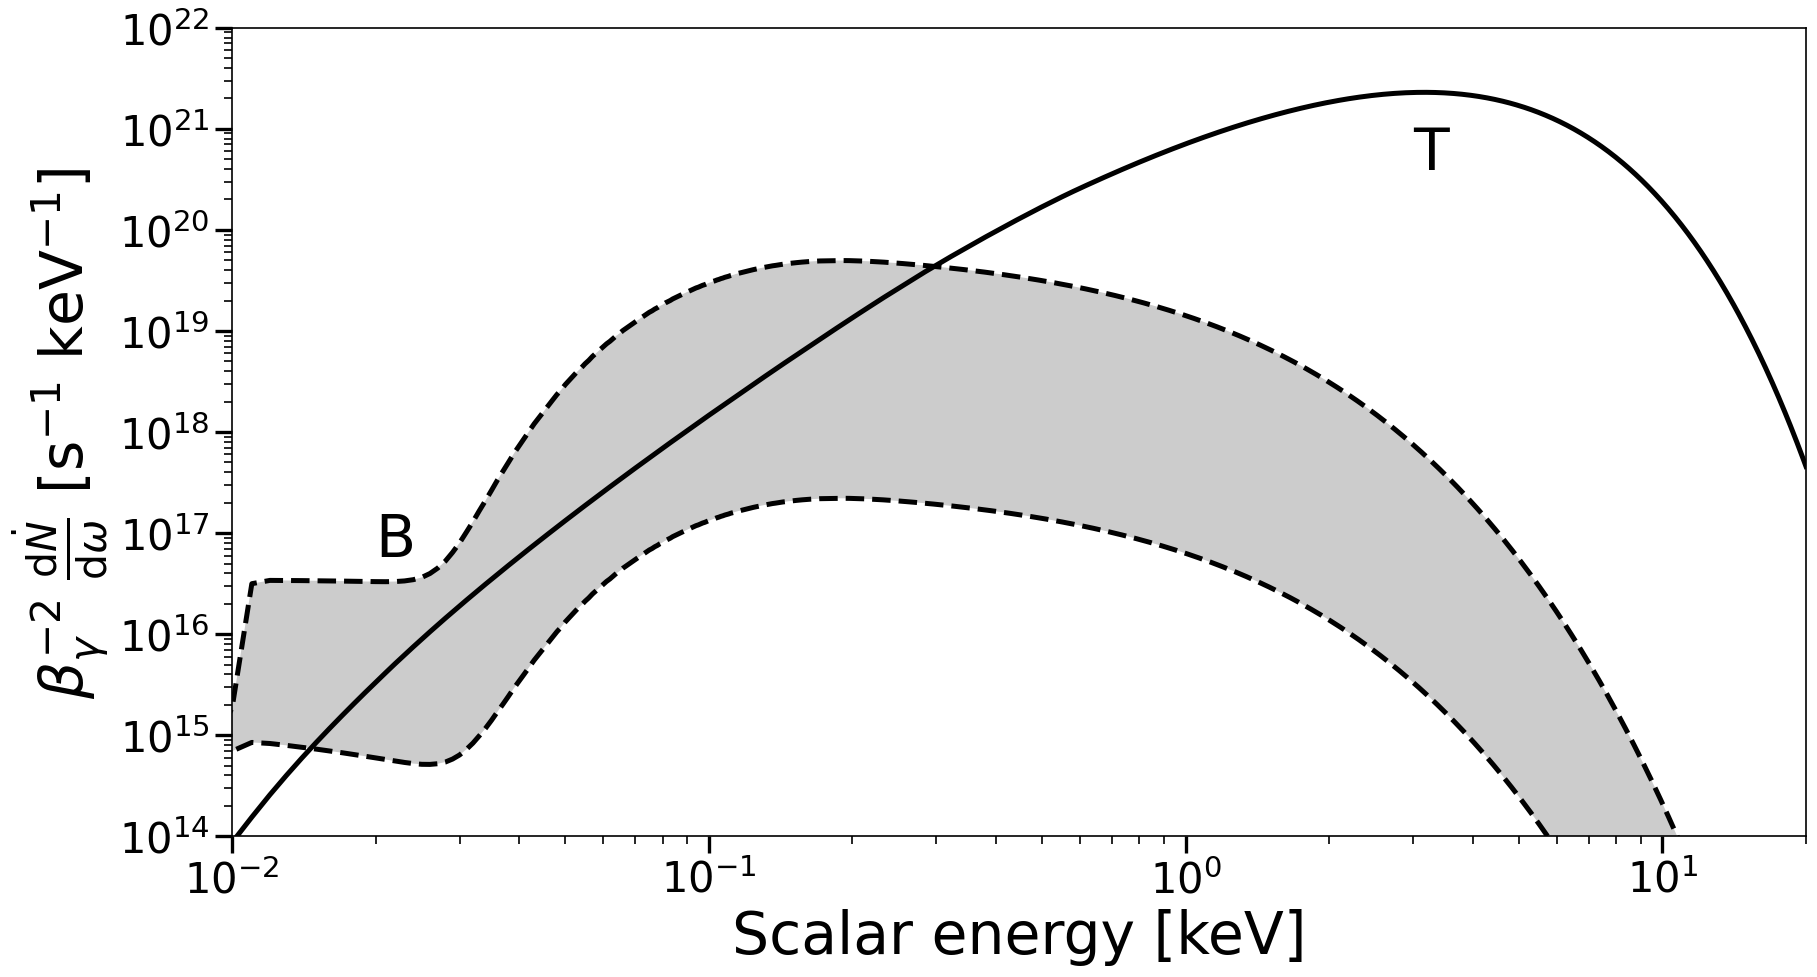

In [11]:
fig2 = plt.figure(1)	# display is 1920 x 1080 (16:9)
ax2 = fig2.subplots()
#ax2.set(xlim=(1e-3,2e1), ylim=(1e-4, 9e5))
ax2.set(xlim=(1e-2,2e1), ylim=(1e14, 1e22))
#ax2.set(xlim=(0,2e1), ylim=(0, 1.5e3))		# T linear limits


# Electron/Ion T
dat = loadtxt(file + "T_spectrum_1e2.dat")
dat[:,1] = dat[:,1]*1e3/s2eV	# convert [eV/eV] to [s-1 keV-1]
ax2.plot(dat[:,0]/1e3,dat[:,1], ls='-',color='k')
ax2.text(3e0,4e20,"T")

# B-field
dat = loadtxt(file + "B_spectrum_1e2.dat")
dat[:,1] = dat[:,1]*1e3/s2eV	# convert [eV/eV] to [s-1 keV-1]
ax2.plot(dat[:,0]/1e3,dat[:,1],color='k', ls='--')
ax2.text(2e-2,6e16,"B")
dat2 = loadtxt(file + "B_spectrum_1e2--lowB.dat")
dat2[:,1] = dat2[:,1]*1e3/s2eV	# convert [eV/eV] to [s-1 keV-1]
ax2.plot(dat2[:,0]/1e3,dat2[:,1],color='k', ls='--')
plt.fill_between(dat2[:,0]/1e3,dat2[:,1],dat[:,1], facecolor='k', alpha=0.2)#, hatch='xx'

# axes
ax2.set_xlabel("Scalar energy [keV]")
ax2.set_ylabel(r'$\beta_\gamma^{-2}\; \frac{\mathrm{d}\dot{N}}{\mathrm{d}\omega}$ [s$^{-1}$ keV$^{-1}$]')	#[m-2 s-1 eV-1]")
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.legend(loc='lower right')

plt.tight_layout()
name = "spectrum_TB--black"
# plt.savefig('plots/pdfs/{}.pdf'.format(name))
plt.show()